# Pattern Recognition - Project #3

*   **Course:** Pattern Recognition - Fall 2020
*   **Instructor:** [Dr. Morteza Analoui](https://www.scopus.com/authid/detail.uri?authorId=16835800400)
*   **Teaching Assistants:** Abolfazl Mahdizade, Pedram Dadkhah
*   **Student:** [Parsa Abbasi](https://parsa-abbasi.ir/)
*   ***Iran University of Science and Technology (IUST)***




## Libraries

In [1]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.27-cp36-none-any.whl size=7333 sha256=afc5a76f5cc01a7205b84c8d497f8576642684e16854649bf8a0c7e6e9a7a2c1
  Stored in directory: /root/.cache/pip/wheels/38/9e/e3/6cde1b6b6141b044c692d88980f26c4fe7806cc92ddd009c8c
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.24-cp36-none-any.whl size=7000 sha256=b69a52521d2f00725279246a61d5ae24ece8370a6bf55b26c633882f25883c95
  Stored in directory: /root/.cache/pip/wheels/0c/3b/5d/f2fb3eff7f2fe268463b91a825816a07cd8458c4fe359f034a
  Created wheel for compress-json: filename=compress_json-1.0.4-cp36-none-any.whl size=4585 sha256=586dbcad703d4ed64946e5f5b464099bd8e80ccdde7f994bb04d2a8181e8a4f3
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [2]:
# General
import gc, os
import numpy as np
from tqdm.notebook import tqdm, trange

# Machine Learning
import tensorflow as tf
from keras import Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from plot_keras_history import plot_history

# Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

## Dataset

The dataset used in this project named [UTSig](http://mlcm.ut.ac.ir/Datasets.html), and can be downloaded from [here](https://drive.google.com/drive/u/1/folders/0B0CjHfsXJLLObEZFNVdoMlFIODg).    
I added the dataset folder shortcuts to my Google Drive, and mounted my Drive in the Colab environment.   
UTSig has 115 classes containing: 27 genuine signatures; 3 opposite-hand signed samples and 42 simple forgeries. Each class belongs to one specific authentic person.

In [3]:
!unzip '/content/drive/MyDrive/UTSig.zip'

Streaming output truncated to the last 5000 lines.
  inflating: UTSig_Crop/C070G11.PNG  
  inflating: UTSig_Crop/C069F26.PNG  
  inflating: UTSig_Crop/C071F04.PNG  
  inflating: UTSig_Crop/C070G08.PNG  
  inflating: UTSig_Crop/C068G11.PNG  
  inflating: UTSig_Crop/C070G07.PNG  
  inflating: UTSig_Crop/C069F28.PNG  
  inflating: UTSig_Crop/C069F06.PNG  
  inflating: UTSig_Crop/C071F21.PNG  
  inflating: UTSig_Crop/C071F02.PNG  
  inflating: UTSig_Crop/C069G01.PNG  
  inflating: UTSig_Crop/C069G22.PNG  
  inflating: UTSig_Crop/C068G10.PNG  
  inflating: UTSig_Crop/C069F02.PNG  
  inflating: UTSig_Crop/C069G21.PNG  
  inflating: UTSig_Crop/C068F27.PNG  
  inflating: UTSig_Crop/C071F19.PNG  
  inflating: UTSig_Crop/C070F24.PNG  
  inflating: UTSig_Crop/C069G26.PNG  
  inflating: UTSig_Crop/C069F25.PNG  
  inflating: UTSig_Crop/C070F25.PNG  
  inflating: UTSig_Crop/C068G26.PNG  
  inflating: UTSig_Crop/C071F01.PNG  
  inflating: UTSig_Crop/C068F24.PNG  
  inflating: UTSig_Crop/C070G03.PNG  

In [4]:
dataset_path = '/content/UTSig_Crop/'

In [5]:
# Number of genuine signatures per class (person)
G_num = 27
# Number of forgeries signatures per class (person)
F_num = 45
# Number of classes (persons)
c_num = 115

In [6]:
os.mkdir(dataset_path + 'genuine')
os.mkdir(dataset_path + 'genuine/train')
os.mkdir(dataset_path + 'genuine/test')
dataset_gen_path = dataset_path + 'genuine/'

## Organizing

Organizing image files into the appropriate format for the Image Data Generator.The structure of the data directory are as follow:
- genuine
  - train
    - class_0
      - 0_image_0.png
      - 0_image_1.png
      - ...
      - 0_image_21.png
    - class_1
    - ...
    - class_114
  - test
    - class_0
      - 0_image_22.png
      - 0_image_23.png
      - ...
      - 0_image_26.png
    - class_1
    - ...
    - class_114

In [7]:
for c in trange(c_num):

  class_id = c + 1
  class_id_str = str(class_id).zfill(len(str(c_num)))
  
  # Make a subdirectory for this class
  train_subdirectory = dataset_gen_path + '/train/class_' + str(c)
  os.mkdir(train_subdirectory)
  test_subdirectory = dataset_gen_path + '/test/class_' + str(c)
  os.mkdir(test_subdirectory)

  # For each genuine
  for g in range(G_num):
    genuine_id = g + 1
    genuine_id_str = str(genuine_id).zfill(len(str(G_num)))
    file_name = 'C' + class_id_str + 'G' + genuine_id_str + '.PNG'
    file_path = dataset_path + file_name
    if g < 22:
      dest_path = train_subdirectory + '/' + str(c) + '_image_' + str(g) + '.png'
      os.replace(file_path, dest_path)
    else:
      dest_path = test_subdirectory + '/' + str(c) + '_image_' + str(g) + '.png'
      os.replace(file_path, dest_path)

## Visualization

Let's take a look at some genuine signatures of the first class (person).

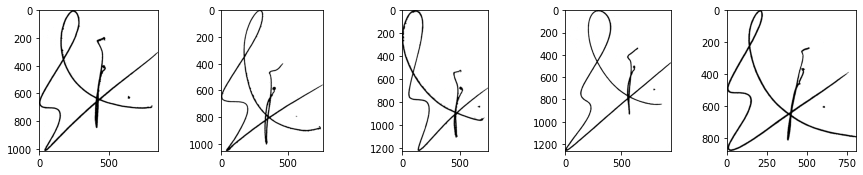

In [8]:
plt.figure(figsize=(15,15)) # specifying the overall grid size

for i in range(5):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    img = mpimg.imread('/content/UTSig_Crop/genuine/train/class_0/0_image_'+ str(i) +'.png')
    plt.imshow(img, cmap='gray')

plt.show()

Now we'll justly split the dataset into three data generators.   
There are 22 images for each class in the train directory.   
We use 4 images per class to validate our model and the remaining 18 images for its training.   
Also, we already split 5 images per class for the test time.

<font color='red'>**Notes:**</font>
- The shuffle of data in the generators will be automatically applied at the run time.
- At each epoch, the data generator will transform the original images into augmented images using the defined features. So our model will see the variant transformations of images at each epoch.


In [9]:
src_path_train = dataset_gen_path + '/train/'
src_path_test = dataset_gen_path + '/test/'

train_datagen = ImageDataGenerator(
        rescale = 1 / 255.0,
        rotation_range=  20,
        zoom_range = 0.05,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        horizontal_flip = True,
        fill_mode = "nearest",
        validation_split = 0.20)

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)

In [10]:
batch_size = 16
target_size = (299, 299)
train_generator = train_datagen.flow_from_directory(
    directory = src_path_train,
    target_size = target_size,
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'training',
    shuffle = True
)
valid_generator = train_datagen.flow_from_directory(
    directory = src_path_train,
    target_size = target_size,
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'validation',
    shuffle = True
)
test_generator = test_datagen.flow_from_directory(
    directory = src_path_test,
    target_size = target_size,
    color_mode = "rgb",
    batch_size = 1,
    class_mode = None,
    shuffle = False
)

Found 2070 images belonging to 115 classes.
Found 460 images belonging to 115 classes.
Found 575 images belonging to 115 classes.


We need true labels for the test data at the evaluation time, so let's extract and remember them.

In [11]:
test_true_labels = test_generator.classes

In [12]:
# Forcing an immediate garbage collection
gc.collect()

10522

## InceptionV3

![picture](https://drive.google.com/uc?id=18c3Q5kx58NGvHZEmIw13jc8APi18FMDI)

As the dataset doesn't contain much data, it's better to using a pre-trained model instead of training a full CNN architecture.   
The pre-trained model used in this project is called Inception V3 that is 48 layers deep. It's trained by Google on more than a million images from the ImageNet database to classify images into 1000 object categories.   
We will use this model to produce a feature embedding vector for each image and employing this embedding for our classifier. To do this the following modification will be applied to Inception architecture:
1. We tell Keras to not include the fully-connected layer at the top of the Inception network.
2. We set the trainable parameter of each layer to be off (freezing the network)
3. We add a 2D Global Average Pooling after the last Concatenate layer. Therefore the feature embedding will be transformed to a single 2048 size vector.
4. We add our Fully Connected layer (here with 1024 neurons), and optionally a Dropout layer after that.
5. Finally, we use a softmax layer to calculate the score for each of the classes.

In [13]:
# Loading Inception-V3 model
model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# Freeze layers
for layer in model.layers:
	layer.trainable = False

# Add our classifier to the end of the model
flat1 = GlobalAveragePooling2D()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
dropout1 = Dropout(0.1)(class1)
output = Dense(c_num, activation='softmax')(dropout1)

model = Model(inputs=model.inputs, outputs=output)

model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [14]:
# As the problem have multi-class we should use categorical_crossentropy loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [16]:
model_hist = model.fit(train_generator,
                       steps_per_epoch = STEP_SIZE_TRAIN,
                       validation_data = valid_generator,
                       validation_steps = STEP_SIZE_VALID,
                       epochs=10)

Epoch 1/10
129/129 [==============================] - 65s 422ms/step - loss: 4.5893 - accuracy: 0.0868 - val_loss: 2.3356 - val_accuracy: 0.4621
Epoch 2/10
129/129 [==============================] - 52s 405ms/step - loss: 1.9896 - accuracy: 0.5255 - val_loss: 1.3215 - val_accuracy: 0.6786
Epoch 3/10
129/129 [==============================] - 52s 405ms/step - loss: 1.0047 - accuracy: 0.7514 - val_loss: 0.9823 - val_accuracy: 0.7366
Epoch 4/10
129/129 [==============================] - 52s 407ms/step - loss: 0.7116 - accuracy: 0.8092 - val_loss: 0.7849 - val_accuracy: 0.7723
Epoch 5/10
129/129 [==============================] - 53s 408ms/step - loss: 0.5182 - accuracy: 0.8731 - val_loss: 0.6483 - val_accuracy: 0.8237
Epoch 6/10
129/129 [==============================] - 53s 409ms/step - loss: 0.4030 - accuracy: 0.8947 - val_loss: 0.5480 - val_accuracy: 0.8482
Epoch 7/10
129/129 [==============================] - 52s 407ms/step - loss: 0.3352 - accuracy: 0.9104 - val_loss: 0.5388 - val_ac

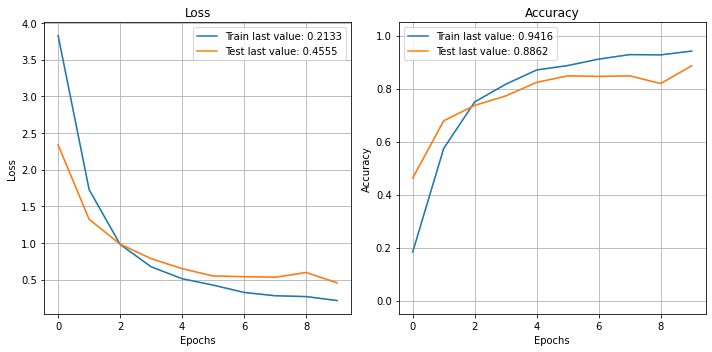

In [17]:
plot_history(model_hist.history)
plt.show()
plt.close()

The learning is done smoothly, and the difference between the validation and training loss is low.

In [18]:
score = model.evaluate(valid_generator)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

29/29 [==============================] - 10s 354ms/step - loss: 0.4091 - accuracy: 0.8739
Validation loss: 0.40913286805152893
Validation accuracy: 0.873913049697876


In [19]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
# Test generator should be reset at each run
test_generator.reset()
# Prediction for test data
pred = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)

575/575 [==============================] - 9s 12ms/step


In [20]:
# Find the class with higher score for each data
predicted_class_indices = np.argmax(pred, axis=1)

In [21]:
# Calculating the accuracy and f1-score
acc = accuracy_score(test_true_labels, predicted_class_indices)
f1 = f1_score(test_true_labels, predicted_class_indices, average='weighted')
print('Test results:', 'accuracy=', acc, ', Weighted F1-score=', f1)

Test results: accuracy= 0.8939130434782608 , Weighted F1-score= 0.8924575183270836


In [22]:
from collections import Counter
true_count = Counter(test_true_labels)
pred_count = Counter(predicted_class_indices)

In [23]:
import plotly.graph_objects as go

import numpy as np

fig = go.Figure()
fig.add_trace(go.Bar(
    x = list(true_count.keys()),
    y = list(true_count.values()),
    name = 'True', # name used in legend and hover labels
    marker_color = '#3498EB',
    opacity = 0.3
))
fig.add_trace(go.Bar(
    x = list(pred_count.keys()),
    y = list(pred_count.values()),
    name = 'Predicted', # name used in legend and hover labels
    marker_color = '#EB4034',
    opacity = 0.8
))

fig.update_layout(
    title_text='Comparing the prediction and true classes', # title of plot
    xaxis_title_text='Class', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

## Classification + Unknown Class

We can use a threshold on the softmax results if we want to consider confidence for the predictions.   
Therefore the image will be classified as an unknown class (class_id = 115) if the maximum softmax value was less than the defined threshold.

In [24]:
threshold = 0.40
new_pred_classes = []

for index, pr in enumerate(pred):
  if max(pr) < threshold:
    new_pred_classes.append(115)
  else:
    new_pred_classes.append(predicted_class_indices[index])

new_pred_classes = np.array(new_pred_classes)

In [25]:
print(new_pred_classes)

[  0   0   0   0   0   1   1   1   1   1   2   2   2   2   2   3   3   3
   3   3   4   4   4   4   4   5   5   5   5   5   6   6   6   6   6  43
   7   7   7   7   8   8   8   8   8   9  68  68   9  66  10  10  10  10
  10  11  11  11  11  11  12  12  49  66  12 115  13  13  13  13  14  14
  14  14  14  15  15  15  15  15  16  16  16  16  16  17  17  17  17  17
  27  18  18  18 115  19  19  19  19  19  20  20  20  60  20  21  21  53
  21  21  22  22  22  22  22  79  79  23  23  67  24  24  24  24  24  25
  25  25  25  25  26  26  26  26  26  27  27  27  27  27  28  28  28  28
  28  29  29  29  29  29  49  66  66  30  30  66  31  31  31  31 115  32
  32  32  32  33  33  33  33  33  34  65  34  34  19  35  35  35 115  35
 115 115  36  36 115  37  37  37  37  37  38  38  38  38  38  39  39  39
  39  39  40  40  40  40  40  41  41  41  41  41 104  42 104  42  42  43
  43  43  43  43  44  44  44  44  44  45  45  45  45  45  46  46  46  46
  46  47  47  47  47  47  48  48  48  48  48  49   

In [26]:
new_acc = accuracy_score(test_true_labels, new_pred_classes)
new_f1 = f1_score(test_true_labels, new_pred_classes, average='weighted')
print('Test results:', 'accuracy=', new_acc, ', Weighted F1-score=', new_f1)

Test results: accuracy= 0.8817391304347826 , Weighted F1-score= 0.8905863218906699
